<big><b><i>Data Investigation Notebook: 2021 brainSPORT rsfMRI TBI Literature Review</i></b></big>


Input directories for the CSV files containing your meta-analysis info. All of the necessary edits can be performed in the Directory class, by editing the baseDir (base directory) and the additional specific locations of each network file. 

Workflow of this notebook is outlined in the README file.

**-df**


In [1]:
%load_ext autoreload

In [2]:

%autoreload 2

import pandas as pd
pd.set_option("display.max_rows", None, "display.max_columns", None)

import numpy as np
import csv

from Scripts.Data_Cleaning import cleanData, smallTable, militaryOnly
from Scripts.Data_Stats import runStats, queryStats, printStats, easyQueryStats, sampleDist, numAuthors, resultsByAge

<i>Setting up directories to CSV files and cleaning the CSVs:</i>

In [3]:
class Directory():
    def __init__(self):
        self.dmn = "PROVIDE DIRECTORY"
        self.ecn = "PROVIDE DIRECTORY"
        self.limbic = "PROVIDE DIRECTORY"
        self.salience = "PROVIDE DIRECTORY"
        self.dan = "PROVIDE DIRECTORY"
        self.van = "PROVIDE DIRECTORY"
        self.sensorimotor = "PROVIDE DIRECTORY"
        self.visual = "PROVIDE DIRECTORY"
        self.ages = "PROVIDE DIRECTORY"

dir = Directory()
#edit your directories for the csv files on your system here

baseDir = "Data/LitReview_CSVs"
dir.dmn = baseDir + "/rsfMRI_TBI_Data - DMN.csv"
dir.ecn = baseDir + "/rsfMRI_TBI_Data - ECN.csv"
dir.limbic = baseDir + "/rsfMRI_TBI_Data - Limbic.csv"
dir.salience = baseDir + "/rsfMRI_TBI_Data - Salience.csv"
dir.dan = baseDir + "/rsfMRI_TBI_Data - DAN.csv"
dir.van = baseDir + "/rsfMRI_TBI_Data - VAN.csv"
dir.visual = baseDir + "/rsfMRI_TBI_Data - Visual.csv"
dir.sensorimotor = baseDir + "/rsfMRI_TBI_Data - Sensorimotor.csv"
dir.ages = "Data/rsfMRI in TBI Meta-Analysis - Ages.csv"

dmn = pd.read_csv(dir.dmn)
ecn = pd.read_csv(dir.ecn)
limbic = pd.read_csv(dir.limbic)
salience = pd.read_csv(dir.salience)
dan = pd.read_csv(dir.dan)
van = pd.read_csv(dir.van)
visual = pd.read_csv(dir.visual)
sensorimotor = pd.read_csv(dir.sensorimotor)


data = [dmn, ecn, limbic, salience, dan, van, visual, sensorimotor]

#edit the following based on the order of your imported networks. IMPORTANT for the next cell's function to count correctly
dataOrder = ["dmn", "ecn", "limb", "sn", "dan", "van", "vis", "smn"]
netLabels = dataOrder

    
#BEFORE PROCESSING (unhash if you want to see initial dataframes)
#for i in range(len(data)):
#    display(data[i])

#actually clean the data!

data = cleanData(data)

#AFTER PROCESSING: (unhash code if you want to print the outputs) 

#netLabels = ["DMN", "ECN", "Limbic", "Salience", "DAN", "VAN", "Visual", "Sensorimotor"]
#for i in range(len(data)):
    #print(netLabels[i] + ":")
    #display(data[i])
            
smallData = smallTable(data)
display(smallData)

numAuthors(smallData)



,WITHIN NETWORK FINDINGS,TBI Class,Severity,Age,Chronicity,Control Type
0,Mayer (2011) University of New Mexico,civilian,mild,adult,ac/subac,HC
1,"Rajesh (2017) Iowa City, Iowa",civilian,mild,adult,chronic,HC
2,Sharp (2011) UK?,civilian,mix severity,adult,chronic,HC
3,"Iraji (2015) Michigan, USA",civilian,mild,adult,Acute,HC
4,"van der Horn (2019) Groningen, Netherlands",civilian,m/mod,adult,subacute + subac/chron,HC
5,"De Simoni (2016) London, UK",civilian,mod/sev,adult,ac/subac,HC
6,"Dretsch (2019), AL&GA,USA",military,mild,adult,chronic,HC
7,"Militana (2016) Tennessee, USA",sport,mild,adult,Acute,HC
8,"van der Horn (2017) #2 Groningen, Netherlands",sport,mild,adult,subacute + chronic,HC
9,"Nathan (2015) Bethesda, MD USA",military,mild,adult,subac/chron,HC


There were 42 many unique author names in the dataframe passed.
Authors found: 
['Arenivas', 'Clough', 'Dailey', 'De Simoni', 'Dretsch', 'Grossner', 'Guo', 'Han', 'Hou', 'Iraji', 'Lancaster', 'Li', 'Lu', 'Manning', 'Mayer', 'Meier', 'Messé', 'Militana', 'Murdaugh', 'Nathan', 'Newsome', 'Orr', 'Pagulayan', 'Palacios', 'Plourde', 'Rajesh', 'Rigon', 'Roy', 'Santhanam', 'Sharp', 'Shumskaya', 'Slobonouv', 'Sours', 'Stevens', 'Tang', 'Threlkeld', 'Vakhtin', 'van der Horn', 'Venkatesan', 'Vergara', 'Zhang', 'Zhou']


Found 50 TBI sample sizes reported in the given data:
[26, 22, 21, 9, 68, 19, 25, 7, 49, 15, 17, 54, 28, 32, 43, 35, 27, 48, 12, 40, 25, 15, 20, 22, 23, 20, 21, 21, 21, 50, 47, 13, 21, 47, 16, 14, 16, 15, 37, 17, 51, 14, 13, 7, 22, 55, 17, 58, 58, 24]

Found 50 Total sample sizes reported in the given data:
[51, 43, 44, 24, 87, 34, 46, 18, 69, 27, 33, 74, 56, 63, 77, 70, 57, 96, 23, 57, 42, 29, 37, 40, 41, 40, 42, 42, 48, 93, 94, 63, 44, 77, 29, 40, 28, 30, 57, 34, 106, 26, 26, 16, 37, 89, 31, 90, 88, 68]

Found 48 average age statistics reported in the given data:
[27.15, 36.16, 37.57, 38.0, 38.3, 38.8, 19.7, 31.3, 25.6, 34.3, 29.0, 37.0, 38.9, 31.7, 41.7, 42.3, 39.0, 28.3, 39.6, 31.7, 30.0, 21.86, 27.5, 34.0, 37.8, 43.0, 51.76, 38.38, 32.9, 41.71, 43.82, 27.9, 41.7, 13.3, 15.99, 24.3, 14.7, 34.9, 17.67, 37.71, 38.81, 20.8, 21.0, 32.4, 35.21, 26.07, 31.4, 16.0]



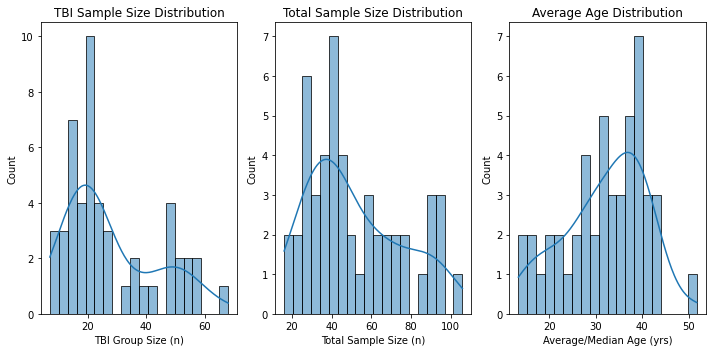

TBI percentiles:
16.25
22.0
39.25


Total percentiles:
33.25
43.5
68.75


Age Quartiles:
26.88
33.45
38.485


Age Deciles: [19.091, 24.82, 27.939999999999998, 31.38, 33.45, 36.327999999999996, 37.98, 38.864, 41.703]


,Increase,Decrease,Null
TBI Age: Decile 1,4,3,7
TBI Age: Decile 2,2,3,10
TBI Age: Decile 3,9,4,13
TBI Age: Decile 4,0,2,8
TBI Age: Decile 5,9,6,7
TBI Age: Decile 6,5,4,4
TBI Age: Decile 7,5,2,4
TBI Age: Decile 8,1,5,11
TBI Age: Decile 9,5,3,27
TBI Age: Decile 10,4,5,4


,Increase,Decrease,Null
TBI Age: 1st Quartile,10,9,25
TBI Age: 2nd Quartile,14,9,20
TBI Age: 3rd Quartile,10,9,18
TBI Age: 4th Quartile,10,10,32


In [4]:
#check sample distributions

#generate dataframe from age CSV file
ageFrame = pd.read_csv(dir.ages)

sample_sizes = sampleDist(data, ageFrame)
#Quartiles (Total N), to be used for running stats and weighting for quartiles
quartiles = [np.percentile(sample_sizes[1], 25), np.percentile(sample_sizes[1], 50), np.percentile(sample_sizes[1], 75)]
#age quartiles, to be used for results by age
age_quartiles = [np.percentile(sample_sizes[2], 25), np.percentile(sample_sizes[2], 50), np.percentile(sample_sizes[2], 75)]

age_percentiles = [np.percentile(sample_sizes[2], 10), np.percentile(sample_sizes[2], 20), np.percentile(sample_sizes[2], 30), np.percentile(sample_sizes[2], 40), np.percentile(sample_sizes[2], 50), np.percentile(sample_sizes[2], 60), np.percentile(sample_sizes[2], 70), np.percentile(sample_sizes[2], 80), np.percentile(sample_sizes[2], 90)]
print('Age Deciles: ' + str(age_percentiles))
resultsByAge(data, ageFrame, age_quartiles, age_percentiles)

In [5]:
#COUNT EVERYTHING UP AND REPORT IT!
#Note: As of latest update, stats now holds UW count, TBI sample size weighted counted, total sample size weighted count (in that order)

classifications = []   #to hold all possible specific classifications

#made it so that no string was contained within another string to make for simpler searching when coming up with statistics
nets = ["dmn", "ecn", "limb", "sn", "dan", "van", "vis", "smn"]
results = ["inc", "dec", "null"]
severities = ["mild", "m/mod", "moderate", "mod/sev", "severe", "mix severity", "No Severity"]
ages = ["child", "adolescent", "adult", "mix age", "No Age"]
chronicities = ["Acute", "ac/subac", "subacute", "subac/chron", "chronic", "repsub", "mix cnicity", "No Cnicity"]
types = ["sport", "military", "civilian", "mix Type"]
controls = ["HC", "ISC", "NCC", "TBI+", "Mood", "Other Control"]

for net in nets:
    for result in results:
        for severity in severities:
            for age in ages:
                for chronicity in chronicities:
                    for typ in types:
                        for control in controls:
                            classifications.append(net + "_" + result + "_" + severity + "_" + age +
                                                   "_" + chronicity + "_" + typ + "_" + control)
                            
stats = [[classi, 0, 0, 0, 0] for classi in classifications]                               

#run the stats!
runStats(data, stats, dataOrder, quartiles)

#PRINT ALL OUR MAIN OUTPUTS!
printStats(stats, "UW")
printStats(stats, "W-TBI")
printStats(stats, "W-Total")
printStats(stats, "Quartiles")

------------------------------

Starting UW Counts...


Network Totals (UW): 


,Increase,Decrease,Null
DMN,23,20,35
ECN,8,7,20
Limbic,3,2,6
Salience/VAN,3,4,11
DAN,1,0,6
Visual,3,3,8
Sensorimotor,4,3,9
Total,45,39,95


All Networks in Detail (UW):


,Increase,Decrease,Null
All,45,39,95
Mild,30,30,55
Mild/Moderate,0,0,10
Moderate,0,0,0
Moderate/Severe,10,3,15
Severe,0,2,1
Mixed Severity,5,4,14
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,4,2,6


Results by Severity & Chronicity (UW)


,Increase,Decrease,Null
Mild Acute,4,7,4
Mild Acute/Subacute,6,5,14
Mild Subacute,4,3,17
Mild Subacute/Chronic,9,6,0
Mild Chronic,7,7,18
Mild Mixed Chronicity,0,0,0
Mild + No Chronicity Stated,0,2,2
Mild/Mod Acute,0,0,0
Mild/Mod Acute/Subacute,0,0,0
Mild/Mod Subacute,0,0,5


DMN in Detail (UW):


,Increase,Decrease,Null
All,23,20,35
Mild,14,14,21
Mild/Moderate,0,0,2
Moderate,0,0,0
Moderate/Severe,6,1,7
Severe,0,2,1
Mixed Severity,3,3,4
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,4,1,4


ECN in Detail (UW):


,Increase,Decrease,Null
All,8,7,20
Mild,6,4,9
Mild/Moderate,0,0,2
Moderate,0,0,0
Moderate/Severe,1,2,3
Severe,0,0,0
Mixed Severity,1,1,6
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,0,1,1


Limbic in Detail (UW):


,Increase,Decrease,Null
All,3,2,6
Mild,2,2,4
Mild/Moderate,0,0,0
Moderate,0,0,0
Moderate/Severe,1,0,1
Severe,0,0,0
Mixed Severity,0,0,1
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,0,0,1


Salience/VAN in Detail (UW):


,Increase,Decrease,Null
All,3,4,11
Mild,2,4,6
Mild/Moderate,0,0,2
Moderate,0,0,0
Moderate/Severe,1,0,2
Severe,0,0,0
Mixed Severity,0,0,1
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,0,0,0


DAN in Detail (UW):


,Increase,Decrease,Null
All,1,0,6
Mild,0,0,6
Mild/Moderate,0,0,0
Moderate,0,0,0
Moderate/Severe,1,0,0
Severe,0,0,0
Mixed Severity,0,0,0
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,0,0,0


Visual in Detail (UW):


,Increase,Decrease,Null
All,3,3,8
Mild,3,3,4
Mild/Moderate,0,0,2
Moderate,0,0,0
Moderate/Severe,0,0,1
Severe,0,0,0
Mixed Severity,0,0,1
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,0,0,0


SMN in Detail (UW):


,Increase,Decrease,Null
All,4,3,9
Mild,3,3,5
Mild/Moderate,0,0,2
Moderate,0,0,0
Moderate/Severe,0,0,1
Severe,0,0,0
Mixed Severity,1,0,1
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,0,0,0


------------------------------
------------------------------
------------------------------
------------------------------

Starting W-TBI Counts...


Network Totals (W-TBI): 


,Increase,Decrease,Null
DMN,547,432,1018
ECN,222,176,691
Limbic,104,72,188
Salience/VAN,99,224,437
DAN,21,0,160
Visual,101,94,288
Sensorimotor,87,75,372
Total,1181,1073,3154


All Networks in Detail (W-TBI):


,Increase,Decrease,Null
All,1181,1073,3154
Mild,847,892,1858
Mild/Moderate,0,0,680
Moderate,0,0,0
Moderate/Severe,238,46,243
Severe,0,38,17
Mixed Severity,96,97,356
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,55,23,77


Results by Severity & Chronicity (W-TBI)


,Increase,Decrease,Null
Mild Acute,131,242,121
Mild Acute/Subacute,189,200,529
Mild Subacute,86,51,706
Mild Subacute/Chronic,219,138,0
Mild Chronic,222,235,476
Mild Mixed Chronicity,0,0,0
Mild + No Chronicity Stated,0,26,26
Mild/Mod Acute,0,0,0
Mild/Mod Acute/Subacute,0,0,0
Mild/Mod Subacute,0,0,340


DMN in Detail (W-TBI):


,Increase,Decrease,Null
All,547,432,1018
Mild,355,293,636
Mild/Moderate,0,0,136
Moderate,0,0,0
Moderate/Severe,138,25,117
Severe,0,38,17
Mixed Severity,54,76,112
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,55,16,56


ECN in Detail (W-TBI):


,Increase,Decrease,Null
All,222,176,691
Mild,158,134,345
Mild/Moderate,0,0,136
Moderate,0,0,0
Moderate/Severe,43,21,42
Severe,0,0,0
Mixed Severity,21,21,168
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,0,7,14


Limbic in Detail (W-TBI):


,Increase,Decrease,Null
All,104,72,188
Mild,82,72,164
Mild/Moderate,0,0,0
Moderate,0,0,0
Moderate/Severe,22,0,7
Severe,0,0,0
Mixed Severity,0,0,17
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,0,0,7


Salience/VAN in Detail (W-TBI):


,Increase,Decrease,Null
All,99,224,437
Mild,85,224,249
Mild/Moderate,0,0,136
Moderate,0,0,0
Moderate/Severe,14,0,35
Severe,0,0,0
Mixed Severity,0,0,17
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,0,0,0


DAN in Detail (W-TBI):


,Increase,Decrease,Null
All,21,0,160
Mild,0,0,160
Mild/Moderate,0,0,0
Moderate,0,0,0
Moderate/Severe,21,0,0
Severe,0,0,0
Mixed Severity,0,0,0
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,0,0,0


Visual in Detail (W-TBI):


,Increase,Decrease,Null
All,101,94,288
Mild,101,94,110
Mild/Moderate,0,0,136
Moderate,0,0,0
Moderate/Severe,0,0,21
Severe,0,0,0
Mixed Severity,0,0,21
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,0,0,0


SMN in Detail (W-TBI):


,Increase,Decrease,Null
All,87,75,372
Mild,66,75,194
Mild/Moderate,0,0,136
Moderate,0,0,0
Moderate/Severe,0,0,21
Severe,0,0,0
Mixed Severity,21,0,21
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,0,0,0


------------------------------
------------------------------
------------------------------
------------------------------

Starting W-Total Counts...


Network Totals (W-Total): 


,Increase,Decrease,Null
DMN,1057,843,1807
ECN,424,325,1181
Limbic,186,123,337
Salience/VAN,173,359,681
DAN,44,0,331
Visual,191,184,519
Sensorimotor,196,190,626
Total,2271,2024,5482


All Networks in Detail (W-Total):


,Increase,Decrease,Null
All,2271,2024,5482
Mild,1636,1671,3387
Mild/Moderate,0,0,872
Moderate,0,0,0
Moderate/Severe,438,84,482
Severe,0,75,33
Mixed Severity,197,194,708
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,106,44,176


Results by Severity & Chronicity (W-Total)


,Increase,Decrease,Null
Mild Acute,229,445,244
Mild Acute/Subacute,353,338,987
Mild Subacute,172,102,1198
Mild Subacute/Chronic,453,282,0
Mild Chronic,429,378,832
Mild Mixed Chronicity,0,0,0
Mild + No Chronicity Stated,0,126,126
Mild/Mod Acute,0,0,0
Mild/Mod Acute/Subacute,0,0,0
Mild/Mod Subacute,0,0,436


DMN in Detail (W-Total):


,Increase,Decrease,Null
All,1057,843,1807
Mild,697,574,1146
Mild/Moderate,0,0,174
Moderate,0,0,0
Moderate/Severe,251,42,230
Severe,0,75,33
Mixed Severity,109,152,224
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,106,28,120


ECN in Detail (W-Total):


,Increase,Decrease,Null
All,424,325,1181
Mild,303,241,593
Mild/Moderate,0,0,174
Moderate,0,0,0
Moderate/Severe,77,42,78
Severe,0,0,0
Mixed Severity,44,42,336
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,0,16,40


Limbic in Detail (W-Total):


,Increase,Decrease,Null
All,186,123,337
Mild,146,123,290
Mild/Moderate,0,0,0
Moderate,0,0,0
Moderate/Severe,40,0,16
Severe,0,0,0
Mixed Severity,0,0,31
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,0,0,16


Salience/VAN in Detail (W-Total):


,Increase,Decrease,Null
All,173,359,681
Mild,147,359,406
Mild/Moderate,0,0,174
Moderate,0,0,0
Moderate/Severe,26,0,70
Severe,0,0,0
Mixed Severity,0,0,31
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,0,0,0


DAN in Detail (W-Total):


,Increase,Decrease,Null
All,44,0,331
Mild,0,0,331
Mild/Moderate,0,0,0
Moderate,0,0,0
Moderate/Severe,44,0,0
Severe,0,0,0
Mixed Severity,0,0,0
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,0,0,0


Visual in Detail (W-Total):


,Increase,Decrease,Null
All,191,184,519
Mild,191,184,257
Mild/Moderate,0,0,174
Moderate,0,0,0
Moderate/Severe,0,0,44
Severe,0,0,0
Mixed Severity,0,0,44
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,0,0,0


SMN in Detail (W-Total):


,Increase,Decrease,Null
All,196,190,626
Mild,152,190,364
Mild/Moderate,0,0,176
Moderate,0,0,0
Moderate/Severe,0,0,44
Severe,0,0,0
Mixed Severity,44,0,42
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,0,0,0


------------------------------
------------------------------
------------------------------
------------------------------

Starting Quartiles Counts...


Network Totals (Quartiles): 


,Increase,Decrease,Null
DMN,49,41,89
ECN,24,16,60
Limbic,9,6,15
Salience/VAN,8,16,34
DAN,3,0,16
Visual,10,9,26
Sensorimotor,10,10,30
Total,113,98,270


All Networks in Detail (Quartiles):


,Increase,Decrease,Null
All,113,98,270
Mild,78,81,166
Mild/Moderate,0,0,40
Moderate,0,0,0
Moderate/Severe,23,4,26
Severe,0,3,1
Mixed Severity,12,10,37
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,4,2,8


Results by Severity & Chronicity (Quartiles)


,Increase,Decrease,Null
Mild Acute,10,19,11
Mild Acute/Subacute,19,17,53
Mild Subacute,7,6,57
Mild Subacute/Chronic,23,14,0
Mild Chronic,19,19,39
Mild Mixed Chronicity,0,0,0
Mild + No Chronicity Stated,0,6,6
Mild/Mod Acute,0,0,0
Mild/Mod Acute/Subacute,0,0,0
Mild/Mod Subacute,0,0,20


DMN in Detail (Quartiles):


,Increase,Decrease,Null
All,49,41,89
Mild,30,28,56
Mild/Moderate,0,0,8
Moderate,0,0,0
Moderate/Severe,13,2,12
Severe,0,3,1
Mixed Severity,6,8,12
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,4,1,5


ECN in Detail (Quartiles):


,Increase,Decrease,Null
All,24,16,60
Mild,17,12,31
Mild/Moderate,0,0,8
Moderate,0,0,0
Moderate/Severe,4,2,3
Severe,0,0,0
Mixed Severity,3,2,18
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,0,1,2


Limbic in Detail (Quartiles):


,Increase,Decrease,Null
All,9,6,15
Mild,7,6,13
Mild/Moderate,0,0,0
Moderate,0,0,0
Moderate/Severe,2,0,1
Severe,0,0,0
Mixed Severity,0,0,1
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,0,0,1


Salience/VAN in Detail (Quartiles):


,Increase,Decrease,Null
All,8,16,34
Mild,7,16,21
Mild/Moderate,0,0,8
Moderate,0,0,0
Moderate/Severe,1,0,4
Severe,0,0,0
Mixed Severity,0,0,1
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,0,0,0


DAN in Detail (Quartiles):


,Increase,Decrease,Null
All,3,0,16
Mild,0,0,16
Mild/Moderate,0,0,0
Moderate,0,0,0
Moderate/Severe,3,0,0
Severe,0,0,0
Mixed Severity,0,0,0
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,0,0,0


Visual in Detail (Quartiles):


,Increase,Decrease,Null
All,10,9,26
Mild,10,9,12
Mild/Moderate,0,0,8
Moderate,0,0,0
Moderate/Severe,0,0,3
Severe,0,0,0
Mixed Severity,0,0,3
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,0,0,0


SMN in Detail (Quartiles):


,Increase,Decrease,Null
All,10,10,30
Mild,7,10,17
Mild/Moderate,0,0,8
Moderate,0,0,0
Moderate/Severe,0,0,3
Severe,0,0,0
Mixed Severity,3,0,2
No Severity Stated,0,0,0
Child,0,0,0
Adolescent,0,0,0


------------------------------
------------------------------
------------------------------


In [6]:
easyQueryStats(stats, "UW", "limb", "mild", "Acute")
easyQueryStats(stats, "W-TBI", "dmn", "mild", "ac/subac")
easyQueryStats(stats, "W-Total", "limb", "mild", "subacute")
easyQueryStats(stats, "UW", "limb", "mild", "subac/chron")
easyQueryStats(stats, "UW", "limb", "mild", "chronic")
easyQueryStats(stats, "Quartiles", "dmn", "mild")

You asked for all UW results corresponding to: limb mild Acute   
Here are the results...


,Increase,Decrease,Null
limb mild Acute,0,0,0


You asked for all W-TBI results corresponding to: dmn mild ac/subac   
Here are the results...


,Increase,Decrease,Null
dmn mild ac/subac,55,49,178


You asked for all W-Total results corresponding to: limb mild subacute   
Here are the results...


,Increase,Decrease,Null
limb mild subacute,0,34,183


You asked for all UW results corresponding to: limb mild subac/chron   
Here are the results...


,Increase,Decrease,Null
limb mild subac/chron,1,0,0


You asked for all UW results corresponding to: limb mild chronic   
Here are the results...


,Increase,Decrease,Null
limb mild chronic,1,1,1


You asked for all Quartiles results corresponding to: dmn mild    
Here are the results...


,Increase,Decrease,Null
dmn mild,30,28,56


In [7]:
#Try it out here!








